# Hierarchical and Spectral Clustering LAB.9 Solutions

In this lab we do cluster analysis and implement spectral clustering. Let's start by importing the modules.

In [2]:
import numpy as np  # for linear algebra
import pandas as pd # for dataframe manipulation
import matplotlib.pyplot as plt # for visualization
from sklearn.preprocessing import OrdinalEncoder # for preprocessing
from reduction import PCA # for PCA (our implementation)
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree # for clustering
from clustering import KMeans # (our implmentation)
from sklearn.neighbors import kneighbors_graph # for spectral clusterig NN

import warnings
warnings.filterwarnings('ignore')

## Exercise 1 

Let's start by downloading the dataset, and perform preprocessing

In [3]:
iris = pd.read_csv("../Datasets/iris.data", sep=",", header=None)
# extract X matrix and y data
y = iris[4]
X = iris[[0,1,2,3]]
# preprocess
encoder = OrdinalEncoder()
y = np.array(y)
encoder.fit(y.reshape(-1,1))
y = encoder.transform(y.reshape(-1,1))

Let's plot the data into two dimesions

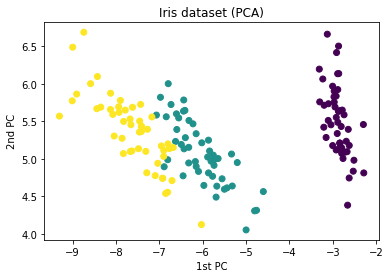

In [4]:
# create the object
pca = PCA()
# fit + transform
pca.fit(X)
X_t = pca.transform(X)
# plot in two dimesions
plt.scatter(X_t[:,0], X_t[:,1], c=y)
plt.title("Iris dataset (PCA)")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()

Let's now perform hierarchical clustering with sigle linkage and ward linkage 

In [5]:
# single linkage
cluster_single = linkage(X, 'single')
# ward linkage
cluster_ward = linkage(X, 'ward')

We can easily plot the dendograms

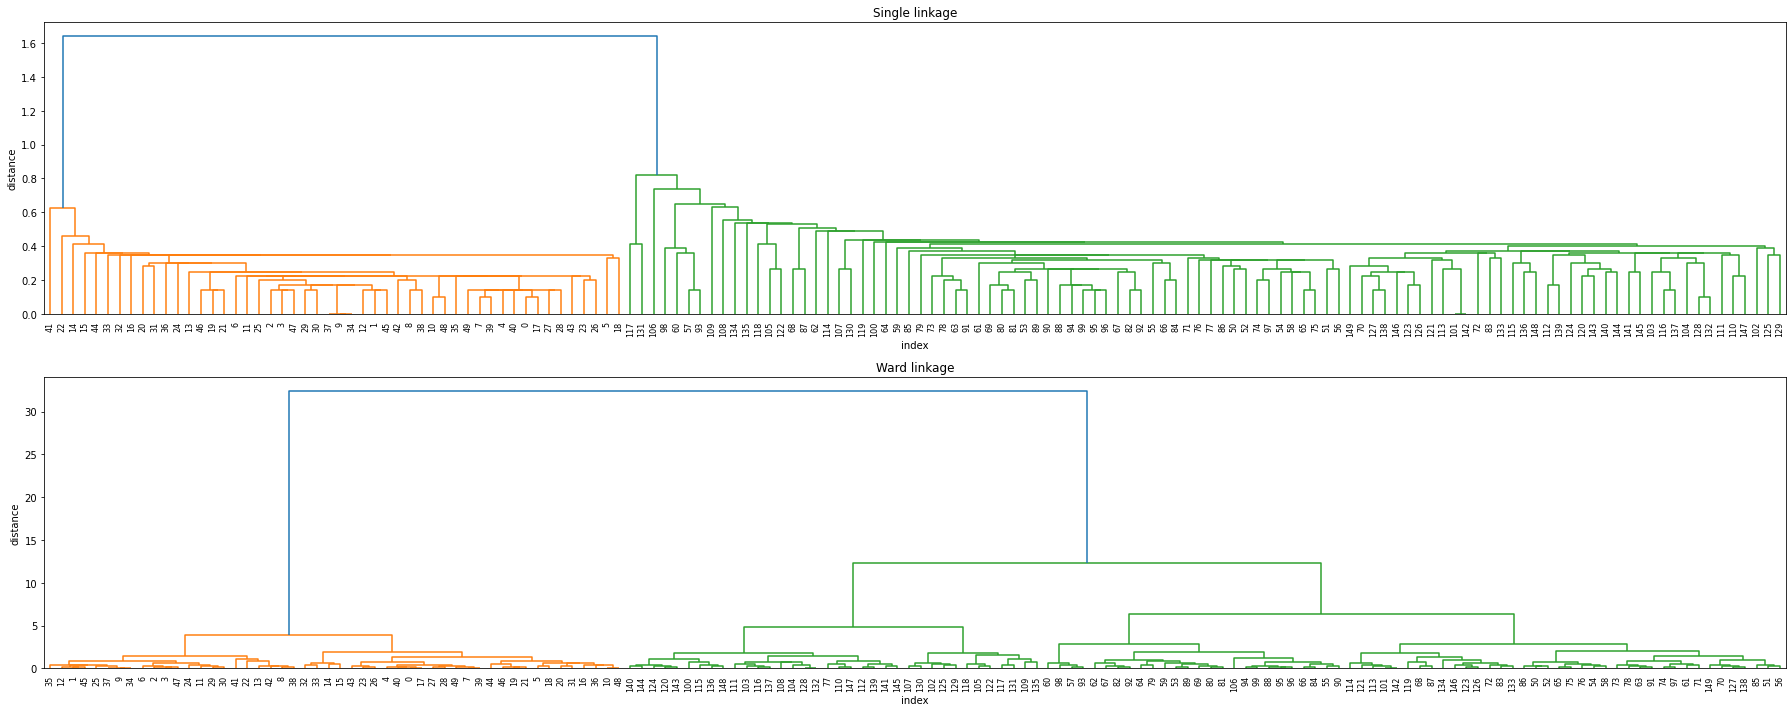

In [6]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.title('Single linkage')
plt.xlabel('index')
plt.ylabel('distance')
dendrogram(cluster_single, leaf_rotation=90.,leaf_font_size=8.)
plt.subplot(2, 1, 2)
plt.title('Ward linkage')
plt.xlabel('index')
plt.ylabel('distance')
dendrogram(cluster_ward, leaf_rotation=90.,leaf_font_size=8.)
plt.tight_layout()

Let's plot the clusters in two dimension, we cut the dendograms so to have the same number of clusters of the ground truth

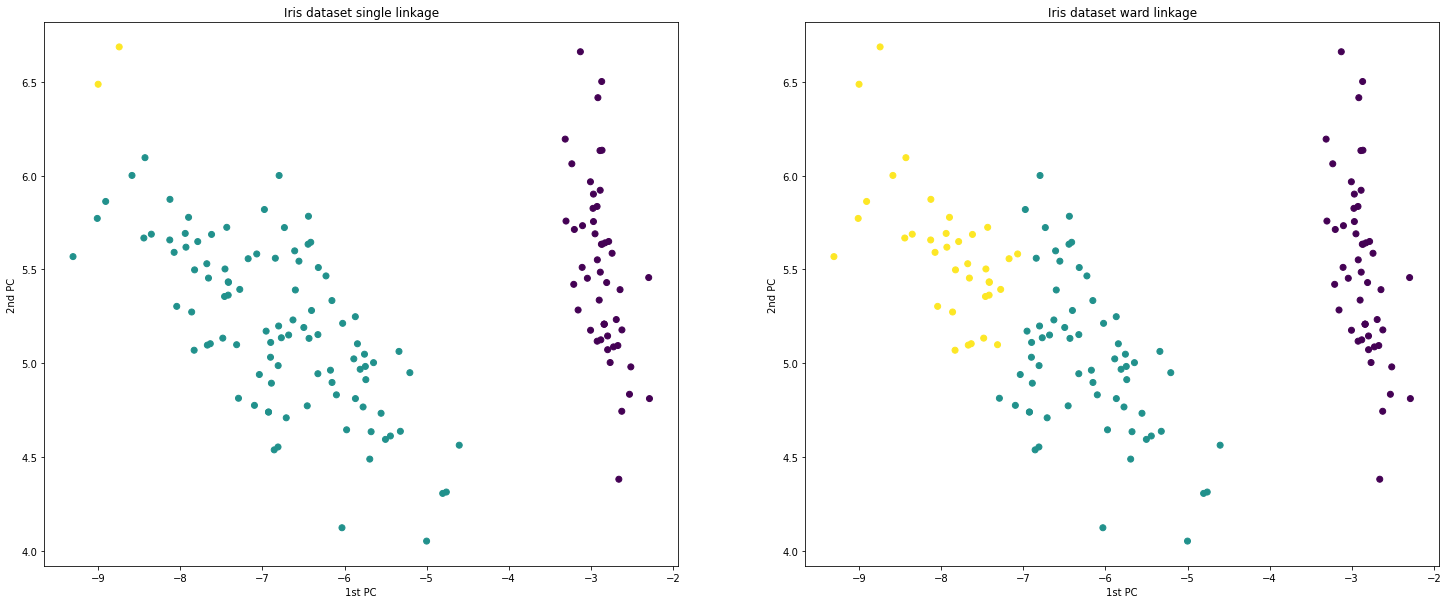

In [7]:
# ground truth clusters
n_clusters = len(np.unique(y))

# cutted clusters
cluster_single_cut = cut_tree(cluster_single, n_clusters=3)
cluster_ward_cut = cut_tree(cluster_ward, n_clusters=3)

# plot into two dimesions
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.scatter(X_t[:,0], X_t[:,1], c=cluster_single_cut)
plt.title("Iris dataset single linkage")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.subplot(1, 2, 2)
plt.scatter(X_t[:,0], X_t[:,1], c=cluster_ward_cut)
plt.title("Iris dataset ward linkage")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()

As we can see single linkage is very noise sensitive, while with Ward linkage we can obtain good clusters.

We now procede to implement Spectral clustering

In [8]:
class SpectralClustering(object):

    def __init__(self, n_clusters, n_neighbors, kwargs={}):

        # small consistency check
        if isinstance(n_clusters, int):
            self.n_clusters = n_clusters
        else:
            ValueError('expected int for n_clusters')

        if isinstance(n_neighbors, int):
            self.n_neighbors = n_neighbors
        else:
            ValueError('expected int for n_neighbors')
        
        # kmeans
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit(self, X):

        # compute laplace matrix
        self._compute_laplace_matrix(X)

        # compute eigenvector
        eigenvals, eigenvects = np.linalg.eig(self.laplace_matrix)

        # sort in ascending order
        idx = eigenvals.argsort()[::-1]   
        eigenvects = eigenvects[:,idx]

        # extract k components
        clustering_data = eigenvects[:, :self.n_clusters]

        # perform clustering
        self.kmeans.fit(clustering_data)

        # labels
        self.labels = self.kmeans.labels

    def _compute_laplace_matrix(self, X):

        # compute connectivity by NN
        connectivity = kneighbors_graph(X, n_neighbors=self.n_neighbors, include_self=True)

        # simmetrize affinity matrix
        self.affinity_matrix_ = (0.5 * (connectivity + connectivity.T)).toarray()

        # compute diagonal matrix
        d_matrix = np.diag(self.affinity_matrix_.sum(1))

        # compute laplacian matrix
        laplace = self.affinity_matrix_ - d_matrix

        # normalization:
        inv_d = np.linalg.pinv(d_matrix)
        self.laplace_matrix = np.dot(np.dot(inv_d, laplace), inv_d)
        

Let's use it to perform spectral clustering

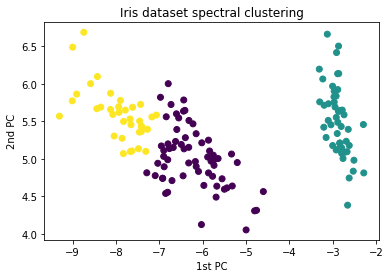

In [9]:
# define spectral clustering and fit
spectral_clustering = SpectralClustering(n_clusters=3, n_neighbors=5)
spectral_clustering.fit(X)
# plot results
plt.scatter(X_t[:,0], X_t[:,1], c=spectral_clustering.labels)
plt.title("Iris dataset spectral clustering")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.show()